<a href="https://colab.research.google.com/github/Marieta3/russian-text-recognition/blob/master/russian-text-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import







In [0]:
import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

# k-means
from sklearn.cluster import KMeans

In [0]:
# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12

### Globalne promenljive

In [0]:
alphabet5 = ["А", "Б", "В", "Г", "Д", "Е", "Ё", "Ж", "З", "И", "Й", "К", "Л", "М", "Н", "О", "П", "Р", "С", "Т", "У", "Ф", "Х", "Ц", "Ч", "Ш", "Щ", "Ъ", "Ы", "Ь", "Э", "Ю", "Я"]
alphabet_lower_case = ["а", "б", "в", "г", "д", "е", "ё", "ж", "з", "и", "й", "к", "л", "м", "н", "о", "п", "р", "с", "т", "у", "ф", "х", "ц", "ч", "ш", "щ", "ъ", "ы", "ь", "э", "ю", "я"]

### Funkcije za obradu slike




In [0]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def dilate(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

### Izdvajanje regiona od interesa

In [0]:
def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

In [0]:
def select_roi(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    #contours1 = remove_inner_rois(contours)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        #zasto 100? 30*42 sa malim greskama
        if area > 100 and h < 100 and h > 15 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
            if not is_inner(x, y, w, h, contours, image_bin.shape): #izbacujemo unutrasnje konture, npr ako imam slovo O
              region = image_bin[y:y+h+1, x:x+w+1]
              regions_array.append([resize_region(region), (x, y, w, h)])
              cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

In [0]:
def select_roi_with_distances(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 15 and w > 20:
          region = image_bin[y:y+h+1, x:x+w+1]
          regions_array.append([resize_region(region), (x, y, w, h)])
          cv2.rectangle(image_orig, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    
    sorted_regions = [region[0] for region in regions_array]
    sorted_rectangles = [region[1] for region in regions_array]
    region_distances = []
    # izdvojiti sortirane parametre opisujucih pravougaonika
    # izracunati rastojanja izmedju svih susednih regiona po X osi i dodati ih u niz rastojanja
    for index in range(0, len(sorted_rectangles) - 1):
        current = sorted_rectangles[index]
        next_rect = sorted_rectangles[index + 1]
        distance = next_rect[0] - (current[0] + current[2]) # x_next - (x_current + w_current)
        region_distances.append(distance)
    
    return image_orig, sorted_regions, region_distances

In [0]:
def is_inner(x2, y2, w2, h2, contours, shape):
  h, w = shape
  for c in contours:
    x1, y1, w1, h1 = cv2.boundingRect(c)
    if not x1 == 0 and not y1 == 0 and not h1 == h and not w1 == w and x1 < x2 < (x2 + w2) < (x1 + w1) and y1 < y2 < (y2 + h2) < (y1 + h1):
      return True
  return False

In [0]:
def remove_inner_rois(contours):
  retVal = []
  to_remove = []
  temp = contours
  
  for i in range (len(contours)):
    x1, y1, w1, h1 = cv2.boundingRect(contours[i])
    for j in range (len(contours)):
      x2, y2, w2, h2 = cv2.boundingRect(contours[j])
      if x1 < x2 < (x2 + w2) < (x1 + w1) and y1 < y2 < (y2 + h2) < (y1 + h1):
        to_remove.append(contours[j])
      else:
        #if np.any(contours[j] not in retVal):
          retVal.append(contours[j])
  print(len(retVal))
  for item in to_remove:
    temp.remove(item)
  print(len(temp))   
  return temp 


### Priprema podataka za obučavanje

In [0]:
def scale_to_range(image):
    return image/255

In [0]:
def matrix_to_vector(image):
    return image.flatten()

In [0]:
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann
#vraca pobudjenost za svaki neuron od 0 do 1

In [0]:
def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

### Neuronska mreža

In [0]:
def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

In [0]:
def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

### Funkcije za redprocesiranje

In [0]:
def training_preprocess(img):
  alf_gray = image_gray(img)
  alf_bin = image_bin(alf_gray)
  alf_bin = erode(alf_bin)
  alf_bin = erode(alf_bin)
  alf_bin = erode(alf_bin)
  #alf_bin = erode(alf_bin)
  return alf_bin

### Funkcije za obučavanje

In [0]:
def train(img_path, alphabet, display = False, epochs = 1000):
  alf_img = load_image(img_path)
  alf_bin = training_preprocess(alf_img)
  if display:
    display_image(alf_img)
    display_image(alf_bin)
  selected_regions_alf, letters_alf = select_roi(alf_img.copy(), alf_bin)
  display_image(selected_regions_alf)

  inputs =prepare_for_ann(letters_alf)
  outputs = convert_output(alphabet)
  ann = create_ann(output_size=len(alphabet))
  ann = train_ann(ann, inputs, outputs, epochs)

  result = ann.predict(np.array(inputs, np.float32))
  print("result")
  print("\n")
  print(display_result(result, alphabet))

### Određivanje pobedničkog neurona

In [0]:
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

### Prikaz rezultata

In [0]:
def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

In [0]:
def display_result_with_spaces(outputs, alphabet, k_means):
    # odredjivanje indeksa grupe koja odgovara rastojanju izmedju reci
    w_space_group = max(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    # iterativno dodavanje prepoznatih elemenata
    # dodavanje space karaktera ako je rastojanje izmedju dva slova odgovara rastojanju izmedju reci
    for idx, output in enumerate(outputs[1:, :]):
        if k_means.labels_[idx] == w_space_group:
            result += ' '
        result += alphabet[winner(output)]
    return result

### Treniranje


Training started...

Training completed...
result


['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


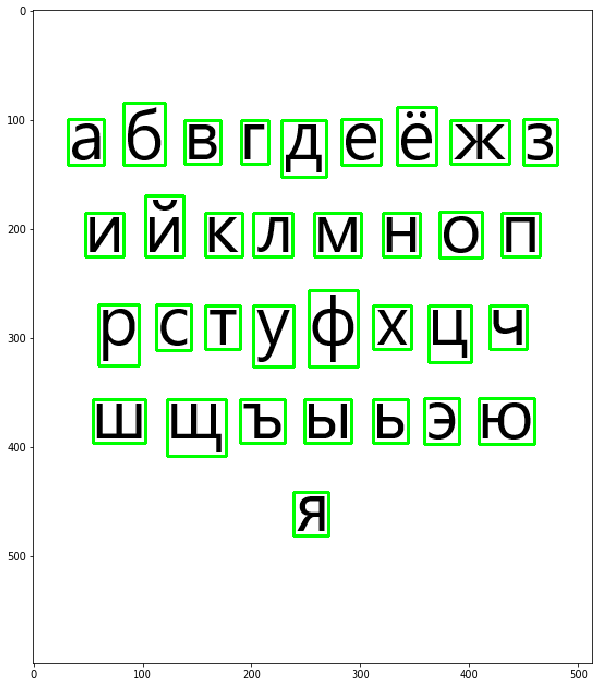

In [73]:
train(img_path='lower_case.png', alphabet=alphabet_lower_case, display=True)